In [1]:
from nipype.interfaces import fsl
from mvpa2.misc.data_generators import autocorrelated_noise

def simulate_run(infile, lfnl=3, hfnl=.5):
    """
    Simple simulation of 4D fmri data. Takes a given functional image,
    performs motion correction, computes the mean and adds autocorrelated
    noise to it.

    Parameters
    ----------
    infile:     str
        Path to the 4D functional image in .nifti format
    outfile:    str
        Path and name of the simulated image
    lfnl:       float
        Low frequency noise level. Default = 3 Hz
    hfnl:       float
        High frequency noise level. Default = None.
    """

    fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

    # perform motion correction using mcflirt implemented by nipype.
    mcfile = infile.replace('.nii.gz', '_mc.nii.gz')
    mcflt = fsl.MCFLIRT(in_file=infile, out_file=mcfile)
    mcflt.run()

    # load the preprocessed nifti as pymvpa data set
    ds = fmri_dataset(mcfile)

    # get TR from sample attributes
    tr = float(ds.sa['time_coords'][1] - ds.sa['time_coords'][0])

    # convert to sampling rate in Hz
    sr = 1.0 / tr
    #cutoff = 1.0 / (2.0 * tr)
    cutoff = sr / 4

    # produce simulated 4D fmri data
    shambold = autocorrelated_noise(ds, sr, cutoff, lfnl=lfnl, hfnl=hfnl)

    # save to nifti file
    #image = map2nifti(shambold)
    #image.to_filename(oswutfile)
    return shambold

In [2]:
# simulate noise
import os
from mvpa2.datasets.mri import fmri_dataset
os.chdir('/host/shambrain/shambrain/data')
noise = simulate_run('bold.nii.gz')

/Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/nipype/interfaces/base.py:370: DeprecationWarning: use "HasTraits.trait_set" instead
  self.set(**kwargs)
/Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/nipype/interfaces/base.py:1063: DeprecationWarning: use "HasTraits.trait_set" instead
  self.inputs.set(**inputs)
/Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/nipype/interfaces/base.py:488: DeprecationWarning: use "HasTraits.trait_get" instead
  out = super(BaseTraitedSpec, self).get(**kwargs)
/Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/nipype/interfaces/base.py:499: DeprecationWarning: use "HasTraits.trait_get" instead
  out = super(BaseTraitedSpec, self).get(**kwargs)


 * Please note: warnings are printed only once, but underlying problem might occur many times *


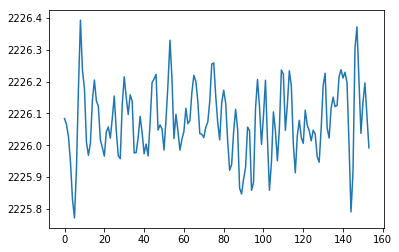

In [3]:
# validate simulated noise image
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.mean(noise.samples, axis=1))
plt.show()

In [2]:
import itertools
import csv

def get_onsets_famface(inpath, run_number=1):
    """
    get event onsets from text file
    """

    if not os.path.exists(inpath):
        raise ValueError('the specified input path does not exist')
    else:
        confiles = os.listdir(inpath)

    famfiles = ['cond002.txt', 'cond003.txt', 'cond004.txt', 'cond005.txt']
    fam_paths = [os.path.join(inpath, confile) for confile in confiles if confile in famfiles]

    unfamfiles = ['cond006.txt', 'cond007.txt', 'cond008.txt', 'cond009.txt']
    unfam_paths = [os.path.join(inpath, confile) for confile in confiles if confile in unfamfiles]

    # collect onsets of all familiar faces
    fam_onsets = []
    for fam in fam_paths:
        with open(fam) as f:
            reader = csv.reader(f, delimiter='\t')
            fam_onsets.append(list(zip(*reader))[0])
    fam_onsets = list(itertools.chain(*fam_onsets))
    fam_onsets = sorted([float(i) for i in fam_onsets])

    # and for unfamiliar faces
    unfam_onsets = []
    for unfam in unfam_paths:
        with open(unfam) as f:
            reader = csv.reader(f, delimiter='\t')
            unfam_onsets.append(list(zip(*reader))[0])
    unfam_onsets = list(itertools.chain(*unfam_onsets))
    unfam_onsets = sorted([float(i) for i in unfam_onsets])

    amplitudes = [8, 1]

    #spec = {'roivalues': [2, 2],    # occipital pole
    #        'conditions': ['fam', 'unfam'], 'onsets': [fam_onsets, unfam_onsets],
    #        'amplitudes': amplitudes, 'durations': [1.5, 1.5]}
    
    #should look like this:
    spec = [{'chunks': 0, 'duration': 1.5, 'onset': fam_onsets, 'targets': 'familiar', 'amplitude': 1, 'roivalue':2},
              {'chunks': 0, 'duration': 1.5, 'onset': unfam_onsets, 'targets': 'unfamiliar', 'amplitude': 1, 'roivalue':2}]
    
    return spec

In [5]:
# get onsets
import os
l1onsets = '/host/shambrain/shambrain/data/l1onsets/'
spec = get_onsets_famface(l1onsets)
print(spec)

[{'onset': [46.0, 52.0, 58.0, 76.0, 100.0, 118.0, 124.0, 130.0, 172.0, 202.0, 214.0, 220.0, 226.0, 238.0, 274.0, 280.0], 'duration': 1.5, 'roivalue': 2, 'amplitude': 1, 'chunks': 0, 'targets': 'familiar'}, {'onset': [28.0, 64.0, 82.0, 88.0, 94.0, 106.0, 112.0, 142.0, 166.0, 190.0, 196.0, 208.0, 244.0, 256.0, 268.0, 286.0], 'duration': 1.5, 'roivalue': 2, 'amplitude': 1, 'chunks': 0, 'targets': 'unfamiliar'}]


In [6]:
# append more to spec

import copy

straightspec = copy.deepcopy(spec)

for cond in straightspec:
    cond['amplitude'] = 8
    cond['roivalue'] = 24
    spec.append(cond)

print(len(spec))
print(spec)

4
[{'onset': [46.0, 52.0, 58.0, 76.0, 100.0, 118.0, 124.0, 130.0, 172.0, 202.0, 214.0, 220.0, 226.0, 238.0, 274.0, 280.0], 'duration': 1.5, 'roivalue': 2, 'amplitude': 1, 'chunks': 0, 'targets': 'familiar'}, {'onset': [28.0, 64.0, 82.0, 88.0, 94.0, 106.0, 112.0, 142.0, 166.0, 190.0, 196.0, 208.0, 244.0, 256.0, 268.0, 286.0], 'duration': 1.5, 'roivalue': 2, 'amplitude': 1, 'chunks': 0, 'targets': 'unfamiliar'}, {'onset': [46.0, 52.0, 58.0, 76.0, 100.0, 118.0, 124.0, 130.0, 172.0, 202.0, 214.0, 220.0, 226.0, 238.0, 274.0, 280.0], 'chunks': 0, 'roivalue': 24, 'amplitude': 8, 'duration': 1.5, 'targets': 'familiar'}, {'onset': [28.0, 64.0, 82.0, 88.0, 94.0, 106.0, 112.0, 142.0, 166.0, 190.0, 196.0, 208.0, 244.0, 256.0, 268.0, 286.0], 'chunks': 0, 'roivalue': 24, 'amplitude': 8, 'duration': 1.5, 'targets': 'unfamiliar'}]


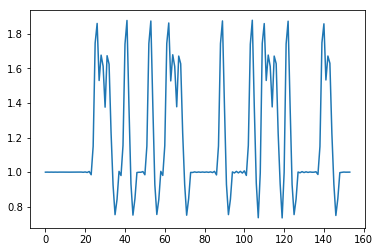

In [7]:
# design used to add signal
onsets = spec[0]['onset']
amplitude = spec[0]['amplitude']
sigchange = 1+(float(amplitude)/100)

from mvpa2.misc.data_generators import simple_hrf_dataset
hrf_model = simple_hrf_dataset(events=onsets, nsamples=154*2, tr=2, tres=1, baseline=1, signal_level=sigchange, noise_level=0).samples[:, 0]

plt.plot(hrf_model)
plt.show()

In [8]:
def add_signal_custom(ds, ms, spec, tpeak=0.8, fwhm=1, fir_length=15):
    """
    add signal to a pure noise simulated image
    (as generated e.g. by simulate_run)
    """

    dataset_with_signal = ds.copy()

    """
    some parameters from data
    """
    #  TR
    tr = ds.sa['time_coords'][1] - ds.sa['time_coords'][0]
    nsamples = len(ds.samples)

    # temporal resolution of hrf model in seconds
    tres = 0.5

    """
    loop over specified conditions
    """
    for cond in spec:
        # condition = spec['conditions'][cond]
        roivalue = cond['roivalue']
        onsets = cond['onset']
        amplitude = cond['amplitude']
        sigchange = float(amplitude) / 100

        # get voxel indices for roi
        roi_indices = np.where(ms.samples[0] == roivalue)[0]

        """
        model hrf
        """
        hrf_model = simple_hrf_dataset(events=onsets, nsamples=nsamples*2, tr=tr, tres=1, baseline=1, signal_level=sigchange,
                                       noise_level=0).samples[:, 0]
        """
        add activation to data set
        """
        # add model activation to roi voxels
        for sample, activation in zip(dataset_with_signal.samples, hrf_model):
            sample[roi_indices] *= activation

    return dataset_with_signal

In [9]:
# load mask file
ms = fmri_dataset('/host/shambrain/shambrain/data/rois_manual_r5_20170222_nooverlap.nii.gz')

In [10]:
# add signal to noise
with_signal = add_signal_custom(noise, ms, spec)

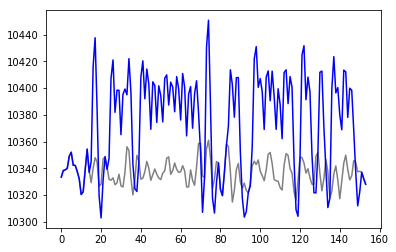

In [11]:
# plot mean roi activation in noise data (grey) and with activation (blue)

roivalue = spec[0]['roivalue']
roi_indices = np.where(ms.samples[0] == roivalue)[0]

roi_mean_withsignal = np.mean(with_signal.samples[:, roi_indices], axis=1)
roi_mean_noise = np.mean(noise.samples[:, roi_indices], axis=1)

plt.plot(roi_mean_noise, color='grey')
plt.plot(roi_mean_withsignal, color='blue')
plt.show()

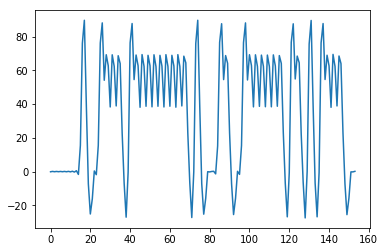

In [12]:
# ... the difference between the two should look like an experimental design
# (with two regressors)
plt.plot(roi_mean_withsignal - roi_mean_noise)
plt.show()

In [13]:
# save the data file
from mvpa2.datasets.mri import map2nifti
image = map2nifti(with_signal)
image.to_filename('testfile.nii.gz')

# Add a time-lagged signal between ROIs for connectivity analysis

In [14]:
"""
New spec only for famfaces
"""

famspec = [cond for cond in spec if cond['targets'] == 'familiar']

# different roivalue
famspec[0]['roivalue'] = 1

# different lags
for cond in famspec:
    cond['lag'] = spec.index(cond)
    cond['amplitude'] = 8

print(famspec)

[{'lag': 0, 'onset': [46.0, 52.0, 58.0, 76.0, 100.0, 118.0, 124.0, 130.0, 172.0, 202.0, 214.0, 220.0, 226.0, 238.0, 274.0, 280.0], 'duration': 1.5, 'roivalue': 1, 'amplitude': 8, 'chunks': 0, 'targets': 'familiar'}, {'lag': 2, 'onset': [46.0, 52.0, 58.0, 76.0, 100.0, 118.0, 124.0, 130.0, 172.0, 202.0, 214.0, 220.0, 226.0, 238.0, 274.0, 280.0], 'chunks': 0, 'roivalue': 24, 'amplitude': 8, 'duration': 1.5, 'targets': 'familiar'}]


In [15]:
def add_signal_lagged(ds, ms, spec):
    """
    Basically the same as with add_signal_custom but onsets are shifted by lag.
    """

    with_lagged_signal = ds.copy()
    tr = ds.sa['time_coords'][1] - ds.sa['time_coords'][0]
    nsamples = len(ds.samples)
    
    """
    Get parameters from spec
    """
    for cond in spec:
        # condition = spec['conditions'][cond]
        roivalue = cond['roivalue']
        amplitude = cond['amplitude']
        sigchange = float(amplitude) / 100
        
        """
        shift onsets by lag in TR units
        """
        lag = cond['lag']
        lag_tr = lag * tr
        onsets = [ons + lag_tr for ons in cond['onset']]
        
        # get voxel indices for roi
        roi_indices = np.where(ms.samples[0] == roivalue)[0]

        """
        model hrf
        """
        hrf_model = simple_hrf_dataset(events=onsets, nsamples=nsamples*2, tr=tr, tres=1, baseline=1, signal_level=sigchange,
                                       noise_level=0).samples[:, 0]
        
        """
        add activation to data set
        """
        for sample, activation in zip(with_lagged_signal.samples, hrf_model):
            sample[roi_indices] *= activation

    return with_lagged_signal

In [16]:
# add time lag signal to noise image
with_lagged_signal = add_signal_lagged(noise, ms, famspec)

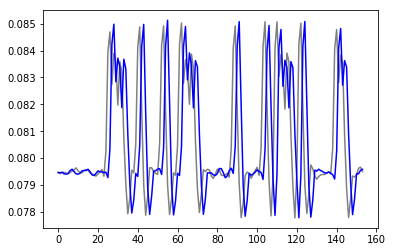

In [17]:
# plot the two different roi time courses (normalized)

# get roi indices
roi_indices_1 = np.where(ms.samples[0] == 1)[0]
roi_indices_24 = np.where(ms.samples[0] == 24)[0]

# calculate mean and normalize
roi_mean_1 = np.mean(with_lagged_signal.samples[:, roi_indices_1], axis=1)
roi_mean_24 = np.mean(with_lagged_signal.samples[:, roi_indices_24], axis=1)

norm1 = roi_mean_1 / np.linalg.norm(roi_mean_1)
norm24 = roi_mean_24 / np.linalg.norm(roi_mean_24)

# plot
plt.plot(norm1, color='grey')
plt.plot(norm24, color='blue')
plt.show()

# Extract ROIs time series

In [18]:
def extract_mean_roi(bold, mask, outfile):

    #ds = fmri_dataset(bold)
    ds = bold
    #ms = fmri_dataset(mask)
    ms = mask

    roitimeseries = []

    for roivalue in range(1, max(ms.samples[0])+1):
        # in mask: set values unequal to the roi value to zero.
        msc = ms.copy()
        msc.samples[0][msc.samples[0] != roivalue] = False
        roi = msc.samples[0]

        # in dataset: set values unequal to roi value to zero.
        ds_masked = ds.copy()
        for sampleindex in range(len(ds_masked.samples)):
            ds_masked.samples[sampleindex][roi == False] = 0

        roitimeseries.append([np.mean(sample) for sample in ds_masked.samples])

    # transpose and write the list
    transposed = map(list, zip(*roitimeseries))
    transposed.insert(0, range(1, max(ms.samples[0]+1)))

    with open(outfile, 'w') as f:
        wr = csv.writer(f)
        wr.writerows(transposed)

In [19]:
extract_mean_roi(with_lagged_signal, ms, '/host/famfaces/rois/lagged/test.csv')

## Extract eigenvariates using fslmeants (implemented in nipype)

In [115]:
# Extract Eigenvariate instead of mean

def extract_eigenv_roi(bold_image, mask_image, workdir, outdir):

    import os
    from nipype.interfaces.fsl.utils import ImageMeants
    
    ms = fmri_dataset(mask_image)
    
    maskspath = os.path.join(workdir, 'roi_masks')
    
    if not os.path.exists(maskpath):
        os.mkdir(maskpath)

    # save seperate mask for each roi to file in workdir
    for roivalue in range(1, max(ms.samples[0])+1):
        msc = ms.copy()
        msc.samples[0][msc.samples[0] != roivalue] = False
        image = map2nifti(msc)
        filename='roi{}_mask.nii.gz'.format(roivalue)
        pathname = os.path.join(workdir, 'roi_masks', filename)
        image.to_filename(filename)

    # extract eigenvariate
    for roifile in os.listdir(os.path.join(workdir, 'roi_masks')):

        extract_eigv = ImageMeants(in_file=bold_image,
                                   terminal_output='file', eig=True,
                                   mask=os.path.join(workdir, 'roi_masks', roifile),
                                   out_file=os.path.join(workdir, 'fslmeants_output_csv',
                                                         'eigenvariates_{}.csv'.format(roifile.replace('_mask.nii.gz',''))))
                                    # nobin=True
        extract_eigv.run()

In [117]:
extract_eigenv_roi('/host/shambrain/shambrain/data/testfile.nii.gz',
                   '/host/shambrain/shambrain/data/rois_manual_r5_20170222_nooverlap.nii.gz',
                   '/host/shambrain/shambrain/data/workdir/',
                   '/host/shambrain/shambrain/data/fslmeants_output_cvs')

TypeError: 'tuple' object is not callable